In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [51]:
# сделаем датасет с определением суммы ущерба при ДТП от водительского стажа, возраста, и мощности машины

n_samples = 1000

driver_exp = np.random.choice(25, n_samples)
age = np.random.choice(80, n_samples) + 17
power = np.random.choice(500, n_samples) + 50

claim = (power*1000)/(age+driver_exp)-18

data = pd.DataFrame({'driver_exp': driver_exp, 'age': age, 'power': power, 'claim': claim})
data.head(5)

,driver_exp,age,power,claim
0,21,47,542,7952.588235
1,10,81,381,4168.813187
2,9,21,138,4582.000000
3,19,37,409,7285.571429
4,3,86,208,2319.078652


In [52]:
# сразу уберем как некачественные строки, где стаж превышает срок, прошедший с 16-летия (возраст, когда можно получить права),
# чтобы данные стали похожи на реальность

data = data[(data['age']-16) > data['driver_exp']]
data.head()

,driver_exp,age,power,claim
0,21,47,542,7952.588235
1,10,81,381,4168.813187
3,19,37,409,7285.571429
4,3,86,208,2319.078652
5,17,48,458,7028.153846


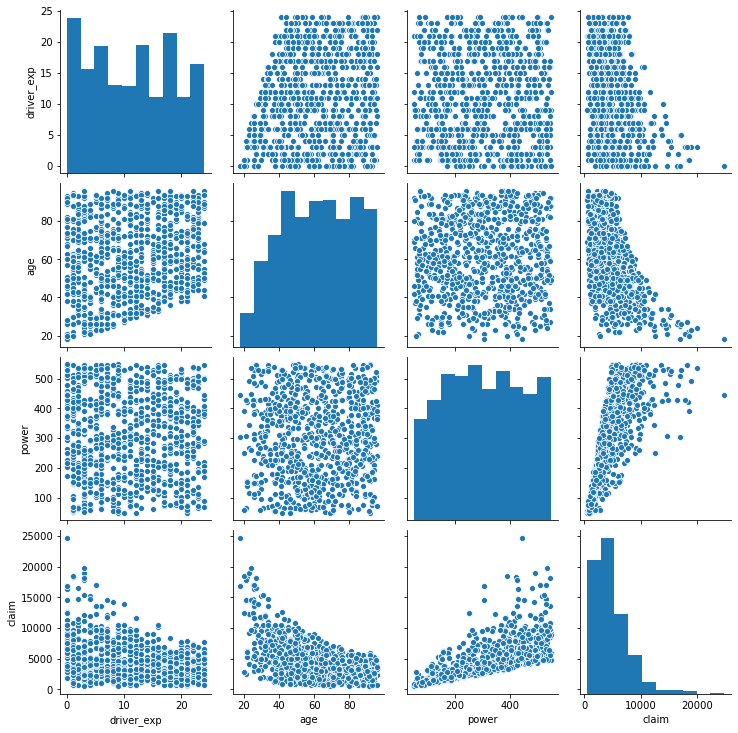

In [22]:
# посмотрим на парные графики
sns.pairplot(data)

In [61]:
# применим к датасету polynomical features

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)

newdata = pd.DataFrame(poly.fit_transform(data))

In [66]:
newdata.columns = ['driver_exp', 'age', 'power', 'claim', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']
newdata.head()

,driver_exp,age,power,claim,f1,f2,f3,f4,f5,f6
0,21.0,47.0,542.0,7952.588235,987.0,11382.0,167004.352941,25474.0,373771.647059,4.310303e+06
1,10.0,81.0,381.0,4168.813187,810.0,3810.0,41688.131868,30861.0,337673.868132,1.588318e+06
2,19.0,37.0,409.0,7285.571429,703.0,7771.0,138425.857143,15133.0,269566.142857,2.979799e+06
3,3.0,86.0,208.0,2319.078652,258.0,624.0,6957.235955,17888.0,199440.764045,4.823684e+05
4,17.0,48.0,458.0,7028.153846,816.0,7786.0,119478.615385,21984.0,337351.384615,3.218894e+06


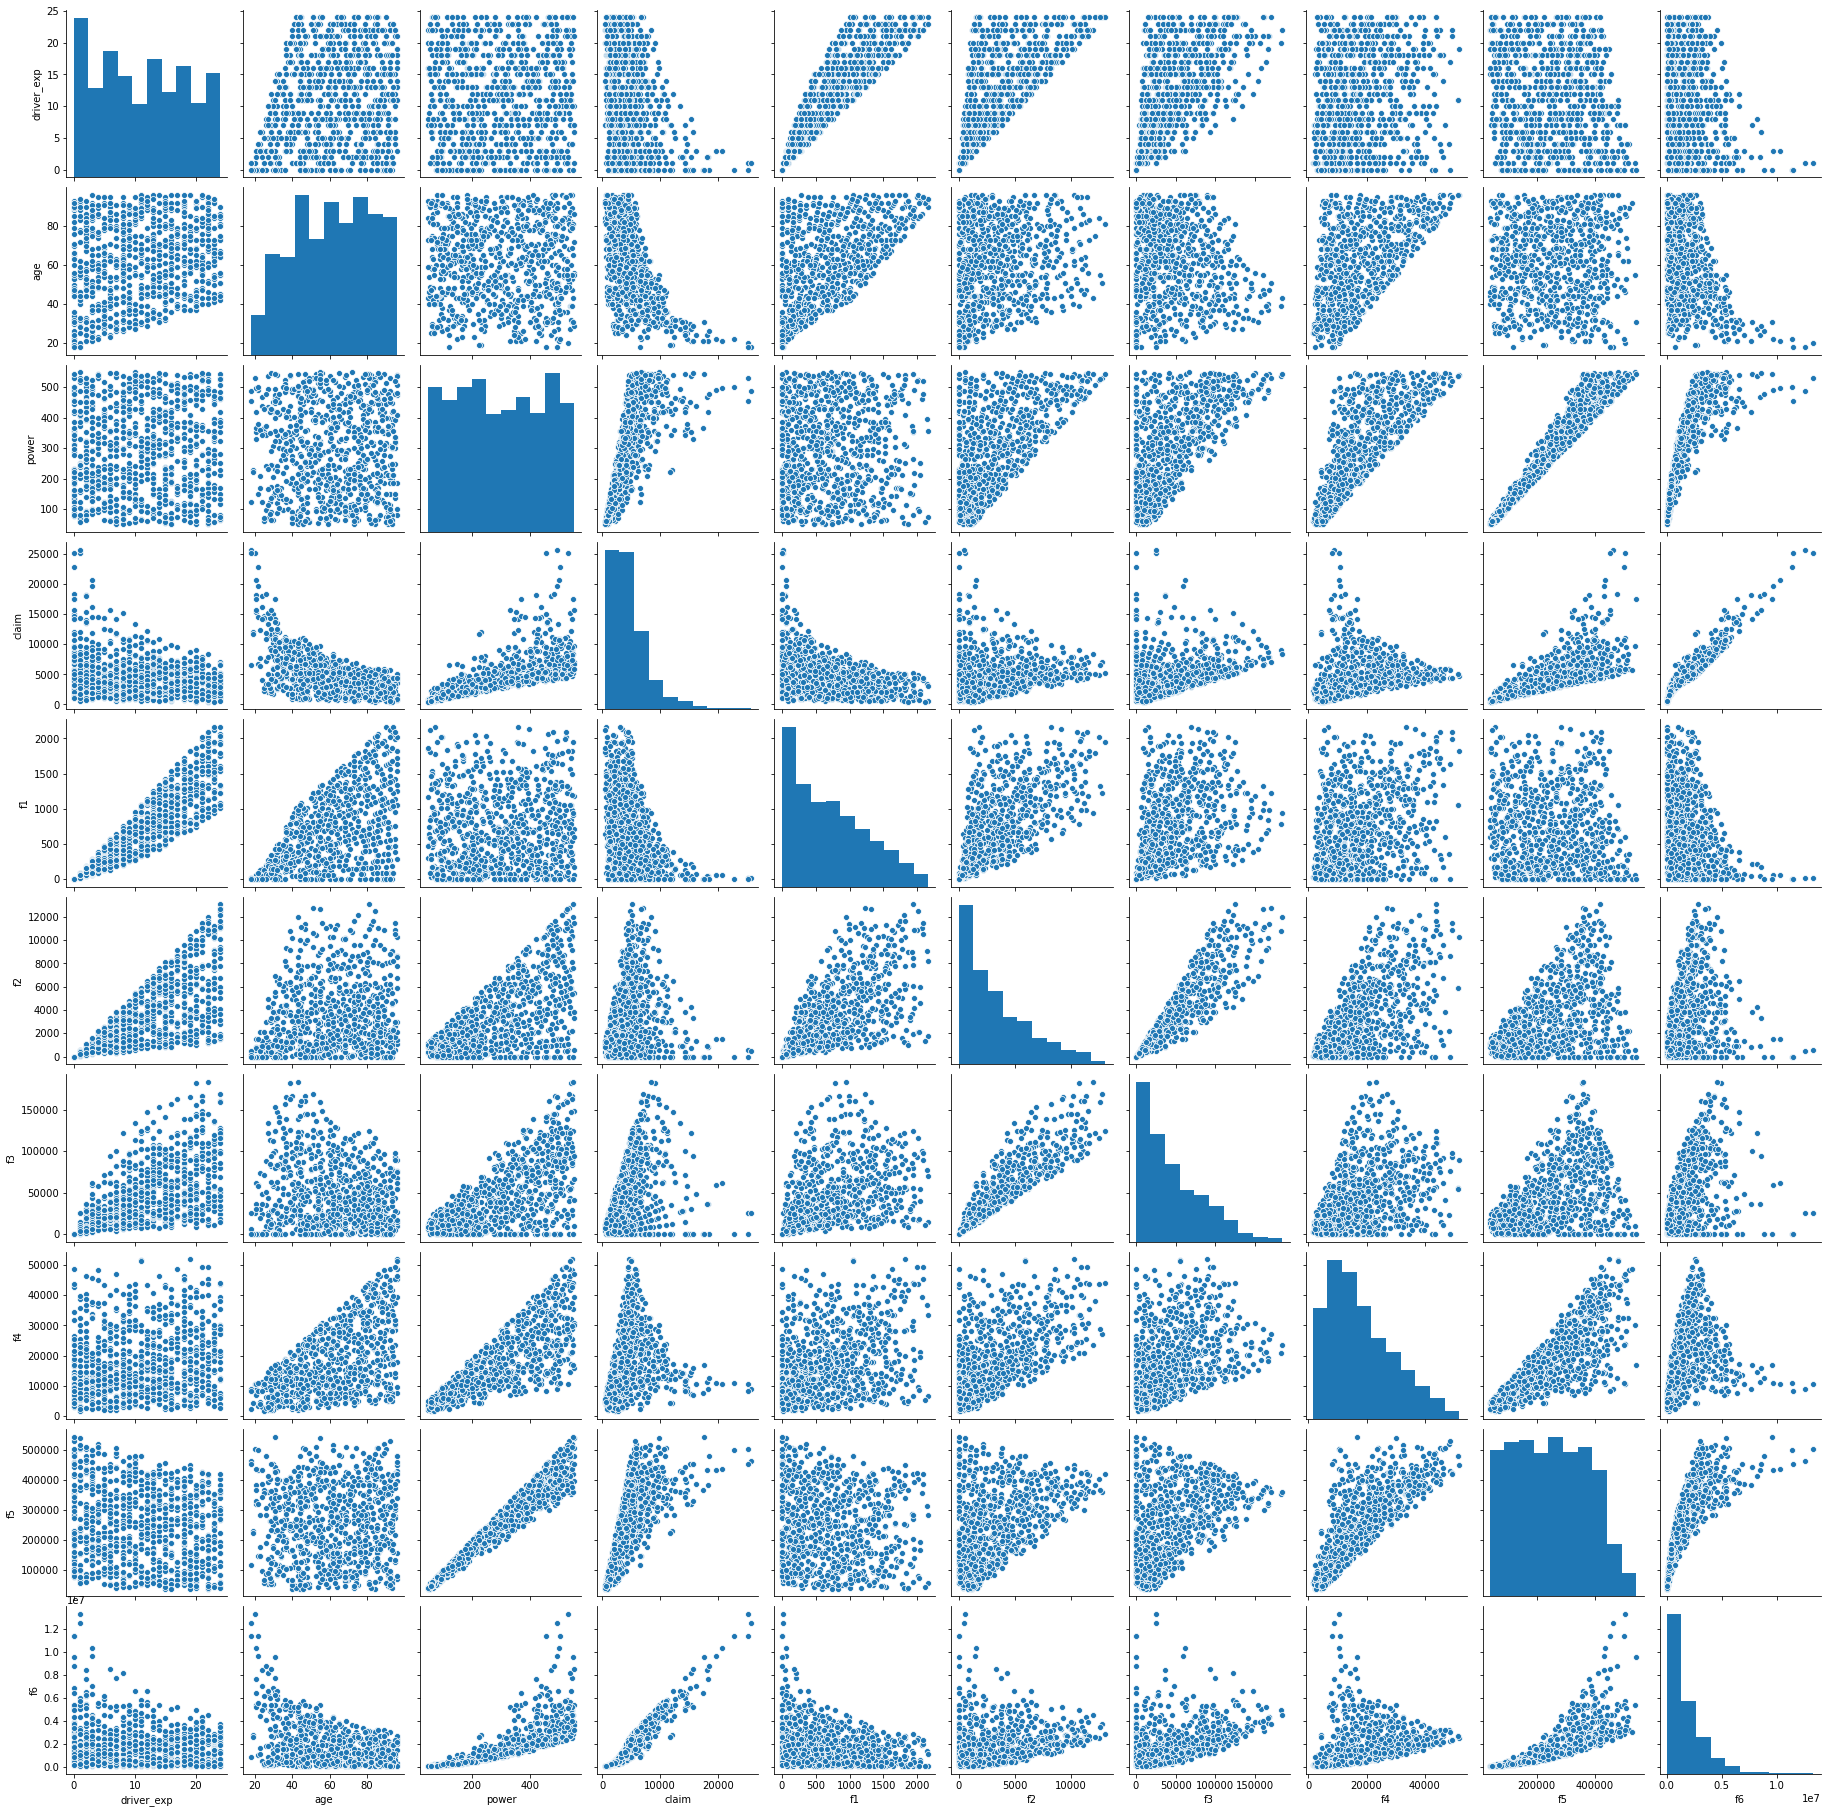

In [67]:
# посмотрим на парные графики еще раз
sns.pairplot(newdata)

In [92]:
# видим, что наша целевая переменная "claim" теперь имеет зависимость, близкую к линейной, с фичей f6, 
# осталось только подобрать коэфициент

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# нормализуем данные, так как линейная модель не работает при одном ненормализованном столце
X = newdata['f6'].values.reshape(-1,1)
y = newdata['claim']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(X)
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [0.00185546]
Bias: 1480.9637344891648
Error: 678.9672624016824


In [95]:
# ошибка получилась 678, чтобы понять много это или мало сравним ее со средним значением ущерба

mean_absolute_error(pred_values, y)/y.mean()

# выходит около 14%. Учитывая, что зависимость изначально заложена не линейная - весьма неплохо

0.1432578036375514

In [97]:
# попробуем добавить остальные фичи, имеющие около-линейную зависимость

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# нормализуем данные, так как линейная модель не работает при одном ненормализованном столце
X = newdata[['f6', 'f5', 'power']]#.values.reshape(-1,1)
y = newdata['claim']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values2 = reg.predict(X)
print('Error: {}'.format(mean_absolute_error(pred_values2, y)))

Weights: [ 2.09847557e-03  3.16759988e-03 -6.62185528e+00]
Bias: 2230.4145241648594
Error: 622.92298937589


In [99]:
# ошибка получилась 622, чтобы понять много это или мало сравним ее со средним значением ущерба

mean_absolute_error(pred_values2, y)/y.mean()

# выходит около 13%. другие фичи добавили 1% точности

0.13143281603544163